In [33]:
import math

import torch
from pyro.distributions import constraints
from pyroapi import pyro

import pyro.distributions as dist
from tqdm import trange

pyro.clear_param_store()

In [34]:
raw_data = torch.concat((torch.tensor([True, True]).repeat(80, 1), torch.tensor([True, False]).repeat(20, 1),
                         torch.tensor([False, True]).repeat(220, 1), torch.tensor([False, False]).repeat(80, 1)))
raw_data, raw_data.size()

(tensor([[ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],


In [35]:
def model_paying_athletes(data):
    student = pyro.sample("student", dist.Categorical(logits=torch.zeros(400)))
    p = pyro.sample("latent_paying", dist.Beta(concentration0=.1, concentration1=.3))
    obs = data[:, 0].clone().detach().float()
    return pyro.sample("obs", dist.Bernoulli(p), obs=obs[student])

In [36]:
def guide_paying_athletes(data):
    student = pyro.sample("student", dist.Categorical(logits=torch.zeros(400)))
    alpha = pyro.param("alpha", torch.tensor(1.), constraint=constraints.positive)
    beta = pyro.param("beta", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("latent_paying", dist.Beta(concentration0=alpha, concentration1=beta))

In [37]:
optim = pyro.optim.Adam({"lr": 0.025})
loss = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model_paying_athletes, guide_paying_athletes, optim, loss)

In [38]:
losses = []
params = []
indicators = []

for _ in trange(10_000):
    l = svi.step(raw_data)
    alpha = pyro.param("alpha")
    beta = pyro.param("beta")
    inferred_mean = alpha / (alpha + beta)
    factor = beta / (alpha * (1.0 + alpha + beta))
    inferred_std = inferred_mean * math.sqrt(factor)
    losses.append({"loss": l})
    params.append({"alpha": alpha.item(), "beta": beta.item()})
    indicators.append({"inferred mean": inferred_mean.item(), "inferred_std": inferred_std.item()})

100%|██████████| 10000/10000 [00:42<00:00, 233.26it/s]


In [39]:
alpha = pyro.param("alpha")
beta = pyro.param("beta")
inferred_mean = alpha / (alpha + beta)
factor = beta / (alpha * (1.0 + alpha + beta))
inferred_std = inferred_mean * math.sqrt(factor)
alpha, beta, inferred_mean, inferred_std

(tensor(95.9208, grad_fn=<AddBackward0>),
 tensor(290.0886, grad_fn=<AddBackward0>),
 tensor(0.2485, grad_fn=<DivBackward0>),
 tensor(0.0220, grad_fn=<MulBackward0>))

In [40]:
import pandas as pd
import matplotlib as plt

<AxesSubplot:>

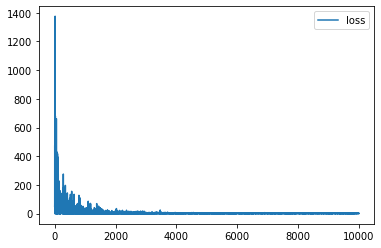

In [41]:
df = pd.DataFrame(losses)

df.plot()

<AxesSubplot:>

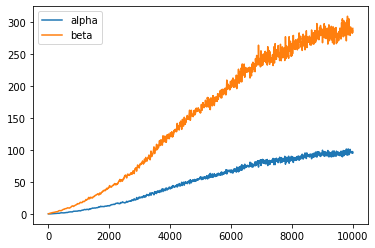

In [42]:
df = pd.DataFrame(params)

df.plot()

<AxesSubplot:>

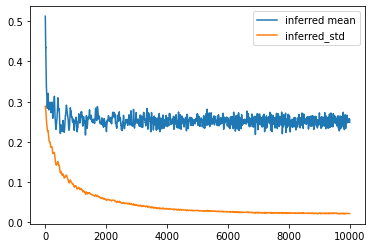

In [43]:
df = pd.DataFrame(indicators)

df.plot()

In [44]:
model_paying_athletes(raw_data)

/home/lukas/Dev/python/sbb/venv/lib/python3.9/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at obs
  warnings.warn(


tensor(0.)

In [45]:
guide_paying_athletes(raw_data)

tensor(0.7494, grad_fn=<SelectBackward0>)